SARIMA with metrics

Root Mean Square Error (RMSE): 0.47
Mean Absolute Percentage Error (MAPE): 5.44%


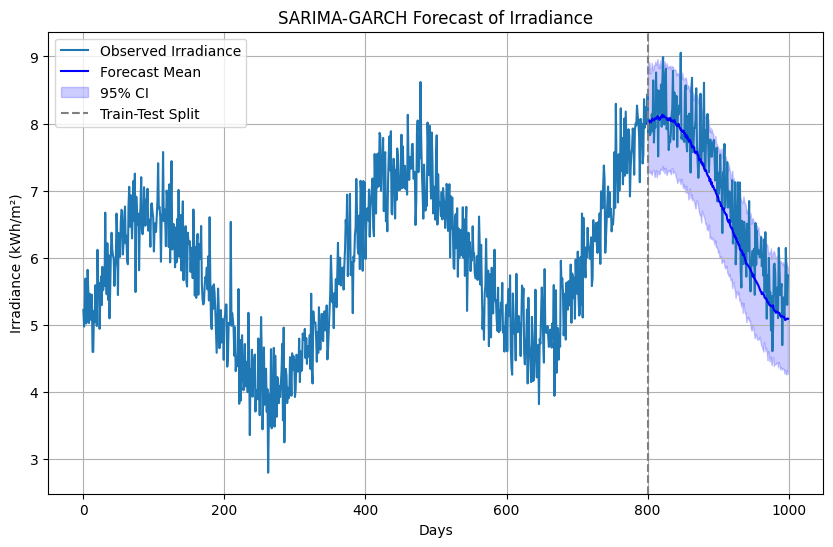

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Simulate irradiance data for demonstration
np.random.seed(42)
n_days = 1000
time = np.arange(n_days)
seasonality = 5 + 1.5 * np.sin(2 * np.pi * time / 365)
trend = 0.002 * time
noise = np.random.normal(0, 0.5, n_days)
volatility = np.sqrt(0.5 + 0.2 * np.abs(np.random.normal(0, 1, n_days)))
residuals = noise * volatility
irradiance = seasonality + trend + residuals

# Split into training and test sets
train_size = int(len(irradiance) * 0.8)
train_data = irradiance[:train_size]
test_data = irradiance[train_size:]

# Create Fourier terms for the entire dataset plus forecast period
def add_fourier_terms(n_periods, period, K):
    time_idx = np.arange(n_periods)
    fourier_terms = pd.DataFrame(index=range(n_periods))
    for k in range(1, K + 1):
        fourier_terms[f'sin_{k}'] = np.sin(2 * k * np.pi * time_idx / period)
        fourier_terms[f'cos_{k}'] = np.cos(2 * k * np.pi * time_idx / period)
    return fourier_terms

# Generate Fourier terms for both training and testing periods
K = 3  # Number of fourier terms
total_periods = len(irradiance)  # Total number of periods including test set
fourier_terms = add_fourier_terms(total_periods, period=365, K=K)

# Split Fourier terms into training and testing sets
exog_train = fourier_terms.iloc[:train_size]
exog_test = fourier_terms.iloc[train_size:train_size + len(test_data)]

# Fit SARIMA model with exogenous variables
sarima_model = SARIMAX(
    train_data,
    order=(1, 1, 1),
    exog=exog_train,
)
sarima_fit = sarima_model.fit(disp=False)
sarima_residuals = sarima_fit.resid

# GARCH model
garch_model = arch_model(sarima_residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

# Forecast using SARIMA with exogenous variables
n_forecast = len(test_data)
sarima_forecast = sarima_fit.get_forecast(steps=n_forecast, exog=exog_test)
sarima_forecast_mean = sarima_forecast.predicted_mean

# GARCH forecast
garch_forecast = garch_fit.forecast(horizon=n_forecast)
simulated_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# Vectorized Monte Carlo simulation
n_simulations = 500
noise_matrix = np.random.normal(0, 1, (n_simulations, n_forecast))
forecast_paths = sarima_forecast_mean.values + (noise_matrix * simulated_volatility)

# Calculate statistics
forecast_mean = forecast_paths.mean(axis=0)
forecast_lower = np.percentile(forecast_paths, 2.5, axis=0)
forecast_upper = np.percentile(forecast_paths, 97.5, axis=0)

# Evaluation
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
mape = mean_absolute_percentage_error(test_data, forecast_mean) * 100

print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plotting
forecast_index = np.arange(len(train_data), len(train_data) + len(test_data))
plt.figure(figsize=(10, 6))
plt.plot(irradiance, label="Observed Irradiance")
plt.plot(forecast_index, forecast_mean, label="Forecast Mean", color="blue")
plt.fill_between(forecast_index, forecast_lower, forecast_upper, color="blue", alpha=0.2, label="95% CI")
plt.axvline(train_size, color="gray", linestyle="--", label="Train-Test Split")
plt.title("SARIMA-GARCH Forecast of Irradiance")
plt.xlabel("Days")
plt.ylabel("Irradiance (kWh/m²)")
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.2115 - val_loss: 0.1381 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.1112 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0777 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0720 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0548 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0488 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0470 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0380 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0357 - val_loss: 0.0993 - learning_rate: 0.0010
Epoch 10/

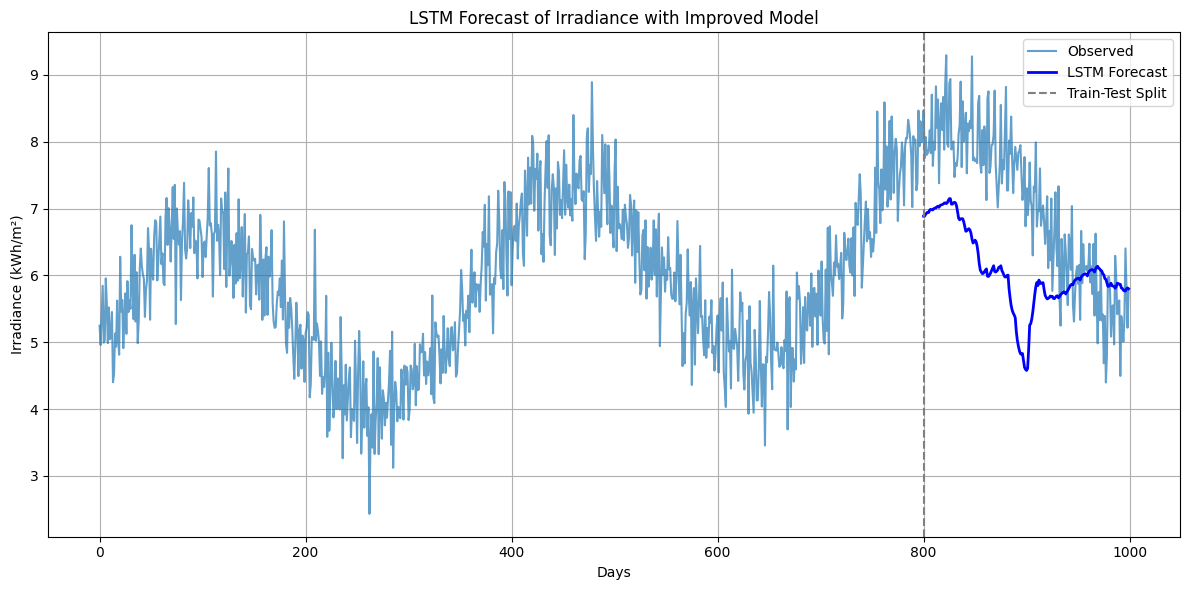

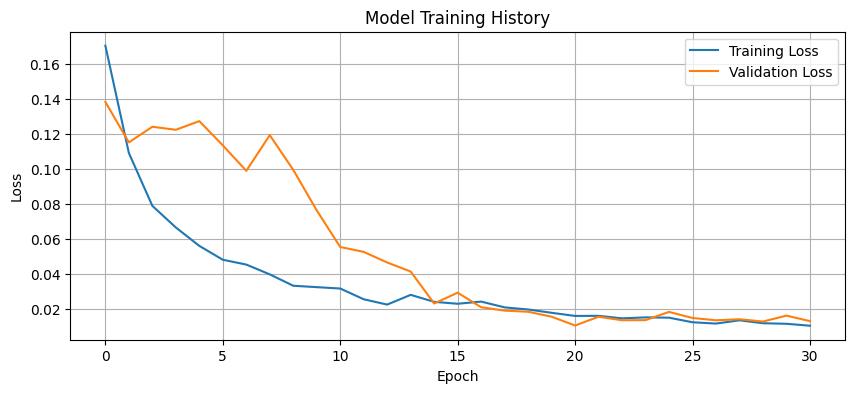

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Simulate irradiance data (replace with real data)
np.random.seed(42)
n_days = 1000
time = np.arange(n_days)
seasonality = 5 + 1.5 * np.sin(2 * np.pi * time / 365)
trend = 0.002 * time
noise = np.random.normal(0, 0.5, n_days)
irradiance = seasonality + trend + noise

# Add time features
def create_time_features(dates):
    return pd.DataFrame({
        'day_of_year': dates % 365,
        'day_of_week': dates % 7,
        'month': (dates % 365) // 30,
        'year_progress': (dates % 365) / 365.0,
    })

# Prepare the data with time features
time_features = create_time_features(time)
features = np.column_stack([
    irradiance.reshape(-1, 1),
    time_features
])

# Split and scale data
train_size = int(len(irradiance) * 0.8)
val_size = int(train_size * 0.2)  # 20% of training data for validation

# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale features and target separately
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(irradiance.reshape(-1, 1))

# Improved sequence creation with stride
def create_windowed_dataset(features, target, window_size, stride=1):
    X, y = [], []
    for i in range(0, len(features) - window_size, stride):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Parameters
window_size = 30  # Increased window size for better pattern recognition
stride = 1  # Can be increased for faster training with large datasets

# Create sequences with validation split
X_temp, y_temp = create_windowed_dataset(
    features_scaled[:train_size],
    target_scaled[:train_size],
    window_size,
    stride
)

# Split into train and validation
train_idx = len(X_temp) - val_size
X_train, X_val = X_temp[:train_idx], X_temp[train_idx:]
y_train, y_val = y_temp[:train_idx], y_temp[train_idx:]

# Create test sequences
X_test, y_test = create_windowed_dataset(
    features_scaled[train_size-window_size:],
    target_scaled[train_size-window_size:],
    window_size,
    stride
)

# Build improved LSTM model
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='huber')  # Huber loss for robustness
    return model

# Initialize callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train model
model = build_lstm_model(input_shape=(window_size, X_train.shape[2]))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Make predictions
train_pred = model.predict(X_train, batch_size=128)
val_pred = model.predict(X_val, batch_size=128)
test_pred = model.predict(X_test, batch_size=128)

# Inverse transform predictions
train_pred = target_scaler.inverse_transform(train_pred)
val_pred = target_scaler.inverse_transform(val_pred)
test_pred = target_scaler.inverse_transform(test_pred)

# Inverse transform actual values for evaluation
y_test_rescaled = target_scaler.inverse_transform(y_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_pred))
mape = mean_absolute_percentage_error(y_test_rescaled, test_pred) * 100

print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot results with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(irradiance, label="Observed", alpha=0.7)

# Plot predictions
test_indices = np.arange(train_size, train_size + len(test_pred))
plt.plot(test_indices, test_pred, label="LSTM Forecast", color='blue', linewidth=2)

# Add training/validation split line
plt.axvline(train_size, color="gray", linestyle="--", label="Train-Test Split")

plt.title("LSTM Forecast of Irradiance with Improved Model")
plt.xlabel("Days")
plt.ylabel("Irradiance (kWh/m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()